# 1141ML Final - DSM 2D, 3D

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cpu")
## ---參數跟之前差不多

sigma_dsm=1.5
batch_size=2048


In [60]:
def sample_noisy_x(batch_size, x_dim=1, sigma=0.5):
    # clean data sampling: mixture of 2 Gaussians
    mu1 = np.array([-2] + [0]*(x_dim-1), dtype=np.float32)
    mu2 = np.array([ 2] + [0]*(x_dim-1), dtype=np.float32)

    w = np.random.rand(batch_size) < 0.5
    x = np.zeros((batch_size, x_dim), dtype=np.float32)

    x[w]  = mu1 + np.random.randn(w.sum(),  x_dim).astype(np.float32)
    x[~w] = mu2 + np.random.randn((~w).sum(), x_dim).astype(np.float32)

    eps = np.random.randn(batch_size, x_dim).astype(np.float32)
    x_tilde = x + sigma * eps

    return x_tilde, eps


In [61]:
class ScoreNet(nn.Module):
    ## x_dim : 整個資料的維度
    def __init__(self, x_dim, hidden, num_layers):
        super().__init__()

        layers = [nn.Linear(x_dim, hidden), nn.SiLU()]
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden, hidden))
            layers.append(nn.SiLU())
        layers.append(nn.Linear(hidden, x_dim))  # output same dimension

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

model=ScoreNet(x_dim =1, hidden=64, num_layers=3).to(device)


def dsm_loss_step(x_dim):
    # 1) sample noisy x_tilde and eps
    x_tilde_np, eps_np = sample_noisy_x(batch_size, x_dim, sigma_dsm)

    x_tilde = torch.from_numpy(x_tilde_np).to(device)
    eps     = torch.from_numpy(eps_np).to(device)

    # 2) predicted score
    s_hat = model(x_tilde)

    # 3) DSM loss
    target = -eps / sigma_dsm
    loss = ((s_hat - target)**2).mean()

    return loss


In [62]:
#### Training Loop
num_steps=5000
lr=5e-3

optimizer=optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,       # lr = lr * 0.5
    patience=200,     # 若 200 steps 沒有改善就降低 lr
    verbose=True
)
loss_history = []

for step in range(1, num_steps+1):
    model.train()

    loss = dsm_loss_step(1)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # scheduler 可有可無
    scheduler.step(loss)

    loss_history.append(loss.item())

    if step % 200 == 0:
        print(f"step {step:4d} | loss = {loss.item():.6f} | lr = {lr:.6f}")


c:\Users\user\.conda\envs\ml_env\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


step  200 | loss = 3.610217 | lr = 0.005000
step  400 | loss = 3.388144 | lr = 0.005000
step  600 | loss = 3.620020 | lr = 0.005000
step  800 | loss = 3.407104 | lr = 0.005000
step 1000 | loss = 3.395375 | lr = 0.005000
step 1200 | loss = 3.362223 | lr = 0.005000
step 1400 | loss = 3.489721 | lr = 0.005000
step 1600 | loss = 3.383750 | lr = 0.005000
step 1800 | loss = 3.591349 | lr = 0.005000
step 2000 | loss = 3.361099 | lr = 0.005000
step 2200 | loss = 3.479125 | lr = 0.005000
step 2400 | loss = 3.450759 | lr = 0.005000
step 2600 | loss = 3.391674 | lr = 0.005000
step 2800 | loss = 3.474561 | lr = 0.005000
step 3000 | loss = 3.395913 | lr = 0.005000
step 3200 | loss = 3.527073 | lr = 0.005000
step 3400 | loss = 3.634434 | lr = 0.005000
step 3600 | loss = 3.474674 | lr = 0.005000
step 3800 | loss = 3.448136 | lr = 0.005000
step 4000 | loss = 3.508492 | lr = 0.005000
step 4200 | loss = 3.515519 | lr = 0.005000
step 4400 | loss = 3.447959 | lr = 0.005000
step 4600 | loss = 3.558294 | lr

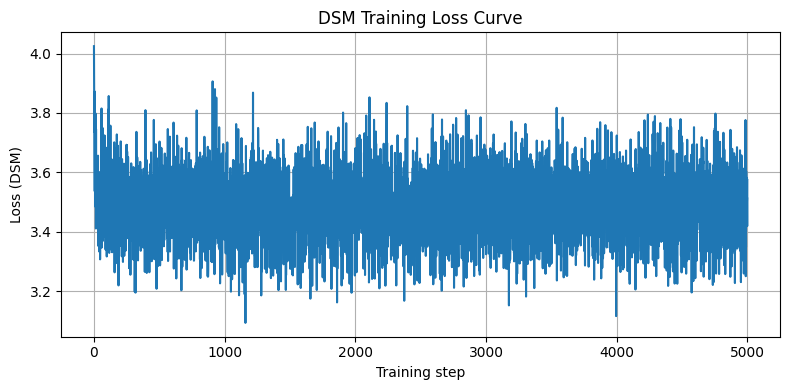

In [63]:
import matplotlib.pyplot as plt

def plot_loss_curve(loss_list):
    """
    loss_list: Python list or Tensor containing loss values for each step
    """
    plt.figure(figsize=(8,4))
    plt.plot(loss_list, linewidth=1.5)
    plt.xlabel("Training step")
    plt.ylabel("Loss (DSM)")
    plt.title("DSM Training Loss Curve")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_loss_curve(loss_history)

## Sampling

### Langevin Dynamics（數學推導）

Langevin dynamics 對應的連續時間 SDE 為：

$$
dx = \nabla \log p(x)\, dt + \sqrt{2}\, dW_t
$$

使用 Euler–Maruyama 方法離散化後可得：

$$
x_{k+1} = x_k + \eta\, \nabla \log p(x_k) + \sqrt{2\eta}\, z_k,
\qquad z_k \sim \mathcal{N}(0, I)
$$

在 score-based 模型中，我們訓練的網路輸出為：

$$
s_\theta(x) \approx \nabla \log p(x)
$$

因此採樣時的離散更新公式為：

```python
x = x + eta * s(x) + torch.sqrt(torch.tensor(2*eta)) * noise


In [64]:
def langevin_sampling(model, steps=2000, eta=0.02, x_dim=1):
    model.eval()

    x = torch.randn(5000, x_dim).to(device)

    for k in range(steps):
        score = model(x)
        noise = torch.randn_like(x)
        x = x + eta * score + torch.sqrt(torch.tensor(2*eta)) * noise

    return x.detach().cpu().numpy()


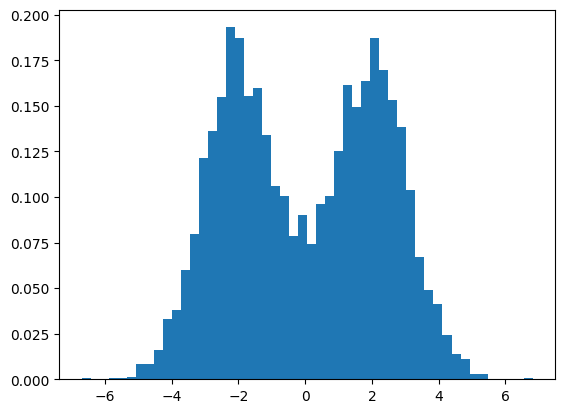

In [65]:
samples = langevin_sampling(model, x_dim=1)
plt.hist(samples, bins=50, density=True)
plt.show()


In [66]:
from matplotlib.gridspec import GridSpec

def langevin_trajectories(model, steps=2000, eta=0.02, x_dim=1,
                          N_total=5000, K_traj=20):
    """
    N_total: 一共多少條軌跡用來做分布
    K_traj : 中間圖要畫出來的軌跡條數
    """
    model.eval()

    # 初始從 N(0,I) 抽樣
    x = torch.randn(N_total, x_dim, device=device)
    x_init_all = x.detach().cpu().numpy().copy()

    # 只記錄前 K_traj 條軌跡
    x_traj = x[:K_traj].clone()
    traj_hist = [x_traj.detach().cpu().numpy().copy()]   # shape (K_traj, x_dim)

    for k in range(steps):
        with torch.no_grad():
            score = model(x)
            noise = torch.randn_like(x)
            x = x + eta * score + torch.sqrt(torch.tensor(2*eta, device=device)) * noise

            x_traj = x[:K_traj]
            traj_hist.append(x_traj.detach().cpu().numpy().copy())

    x_final_all = x.detach().cpu().numpy().copy()
    traj_hist = np.stack(traj_hist, axis=0)   # shape: (steps+1, K_traj, x_dim)

    return x_init_all, x_final_all, traj_hist

steps = 2000
eta = 0.02
x_dim = 1

x_init_all, x_final_all, traj_hist = langevin_trajectories(
    model, steps=steps, eta=eta, x_dim=x_dim,
    N_total=5000, K_traj=20
)


C:\Users\user\AppData\Local\Temp\ipykernel_22896\1853652178.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


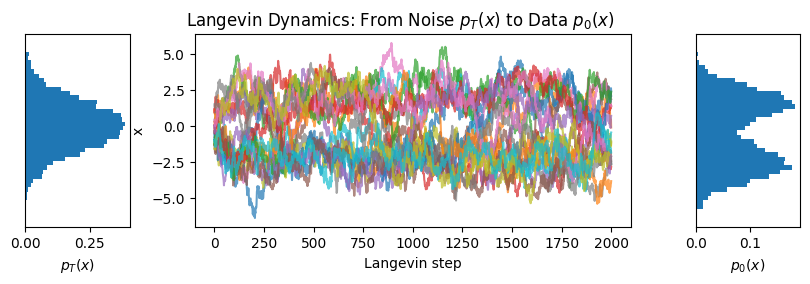

In [54]:
fig = plt.figure(figsize=(10, 2.5))
gs = GridSpec(nrows=1, ncols=3, width_ratios=[1.2, 5, 1.2], wspace=0.3)

ax_left  = fig.add_subplot(gs[0, 0])
ax_mid   = fig.add_subplot(gs[0, 1])
ax_right = fig.add_subplot(gs[0, 2])

# 左邊：初始噪聲分布 p_T(x)
ax_left.hist(x_init_all[:,0], bins=40, density=True,
             orientation="horizontal")
ax_left.set_xlabel(r"$p_T(x)$")
ax_left.set_yticks([])

# 中間：Langevin 軌跡（橫軸用 step 當成 pseudo time）
num_traj = traj_hist.shape[1]
t_axis = np.arange(traj_hist.shape[0])

for i in range(num_traj):
    ax_mid.plot(t_axis, traj_hist[:, i, 0], alpha=0.7)

ax_mid.set_xlabel("Langevin step")
ax_mid.set_ylabel("x")

# 右邊：最終生成分布 p_0(x)
ax_right.hist(x_final_all[:,0], bins=40, density=True,
              orientation="horizontal")
ax_right.set_xlabel(r"$p_0(x)$")
ax_right.set_yticks([])

plt.suptitle("Langevin Dynamics: From Noise $p_T(x)$ to Data $p_0(x)$")
plt.tight_layout()
plt.show()


### Visualization of Langevin Dynamics

The left panel shows the initial distribution $p_T(x)$, which corresponds to 
pure Gaussian noise sampled from $N(0, I)$. At this stage, the samples do not
carry any information about the underlying data distribution.

The middle panel displays several sample trajectories produced by Langevin
dynamics. Each trajectory starts from noise and iteratively updates according to

$$
x_{k+1} = x_k + \eta\, s_\theta(x_k) + \sqrt{2\eta}\, z_k,
$$

where $s_\theta$ is the score network trained via DSM. The trajectories exhibit
stochastic fluctuations due to the injected noise term, but they gradually drift
toward regions of higher probability mass.

The right panel shows the final distribution $p_0(x)$ after all Langevin
updates. The model successfully recovers the bimodal structure of the target
distribution, demonstrating that the learned score function captures the shape
of the mixture-of-Gaussians dataset.


In [55]:
def forward_backward_process(model, steps=2000, eta=0.02, x_dim=1,
                             N_total=5000, K_traj=20, sigma=0.5):

    model.eval()

    # ===== 0: sample real data x0 =====
    x0_np, _ = sample_noisy_x(N_total, x_dim, sigma=0)  # sigma=0 ⇒ 真資料
    x0 = torch.from_numpy(x0_np).to(device)

    # ===== T: forward noise xT = x0 + sigma * eps =====
    eps = torch.randn_like(x0)
    xT = x0 + sigma * eps
    xT_np = xT.detach().cpu().numpy().copy()

    # ===== T → 0' : Langevin dynamics =====
    x = xT.clone()
    xT_traj = x[:K_traj].clone()
    traj_hist = [xT_traj.detach().cpu().numpy().copy()]

    for k in range(steps):
        with torch.no_grad():
            score = model(x)
            noise = torch.randn_like(x)
            x = x + eta * score + torch.sqrt(torch.tensor(2*eta, device=device)) * noise

            xT_traj = x[:K_traj]
            traj_hist.append(xT_traj.detach().cpu().numpy().copy())

    x0_prime_np = x.detach().cpu().numpy().copy()
    traj_hist = np.stack(traj_hist, axis=0)

    return x0_np, xT_np, x0_prime_np, traj_hist


C:\Users\user\AppData\Local\Temp\ipykernel_22896\2033812610.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


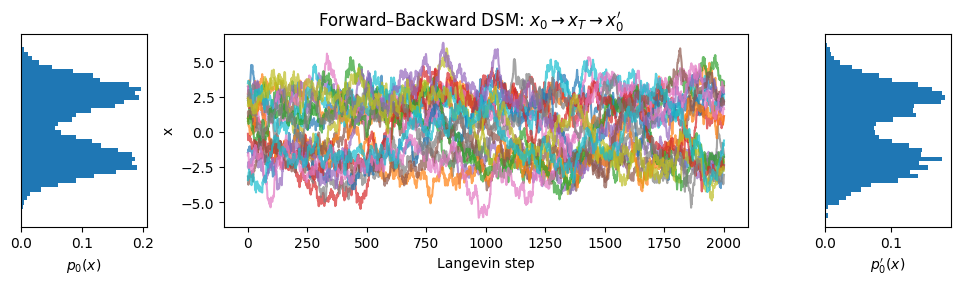

In [56]:
x0_np, xT_np, x0p_np, traj_hist = forward_backward_process(
    model, steps=2000, eta=0.02, x_dim=1, N_total=5000
)

fig = plt.figure(figsize=(12, 2.5))
gs = GridSpec(1, 3, width_ratios=[1.2, 5, 1.2], wspace=0.3)

ax_left  = fig.add_subplot(gs[0, 0])
ax_mid   = fig.add_subplot(gs[0, 1])
ax_right = fig.add_subplot(gs[0, 2])

# 左：真資料 p0(x)
ax_left.hist(x0_np[:,0], bins=40, density=True, orientation='horizontal')
ax_left.set_xlabel(r"$p_0(x)$")
ax_left.set_yticks([])

# 中：Langevin 軌跡（從 xT 回到 x0'）
t_axis = np.arange(traj_hist.shape[0])
for i in range(traj_hist.shape[1]):
    ax_mid.plot(t_axis, traj_hist[:, i, 0], alpha=0.7)
ax_mid.set_xlabel("Langevin step")
ax_mid.set_ylabel("x")

# 右：反向後的 p0'(x)
ax_right.hist(x0p_np[:,0], bins=40, density=True, orientation='horizontal')
ax_right.set_xlabel(r"$p_0'(x)$")
ax_right.set_yticks([])

plt.suptitle(r"Forward–Backward DSM: $x_0 \rightarrow x_T \rightarrow x_0'$")
plt.tight_layout()
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_22896\2934280183.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


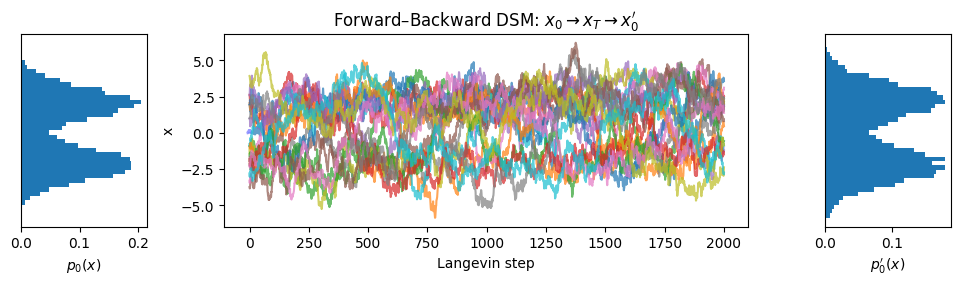

In [57]:
x0_np, xT_np, x0p_np, traj_hist = forward_backward_process(
    model, steps=2000, eta=0.02, x_dim=1, N_total=5000
)


fig = plt.figure(figsize=(12, 2.5))
gs = GridSpec(1, 3, width_ratios=[1.2, 5, 1.2], wspace=0.3)

ax_left  = fig.add_subplot(gs[0, 0])
ax_mid   = fig.add_subplot(gs[0, 1])
ax_right = fig.add_subplot(gs[0, 2])

# 左：p0(x)
ax_left.hist(x0_np[:,0], bins=40, density=True, orientation='horizontal')
ax_left.set_xlabel(r"$p_0(x)$")
ax_left.set_yticks([])

# 中：軌跡 + 透明 xT 直方圖
t_axis = np.arange(traj_hist.shape[0])

# --- 半透明的 xT histogram 疊在軌跡下面 ---
#ax_mid.hist(xT_np[:,0], bins=40, density=True,
#            alpha=0.25, color='gray')   # ★★★ 就這裡！

# 在軌跡背景畫 半透明的 xT 直方圖
ax_mid.hist(
    xT_np[:, 0],
    bins=35,
    density=True,
    alpha=0.35,       # 加大透明度（更明顯）
    color='lightskyblue',
    edgecolor='none'
)

# 再畫一條 KDE 曲線（更明顯）
import seaborn as sns
sns.kdeplot(
    xT_np[:, 0],
    ax=ax_mid,
    color='blue',
    alpha=0.4,
    linewidth=2
)


# --- 畫軌跡 ---
for i in range(traj_hist.shape[1]):
    ax_mid.plot(t_axis, traj_hist[:, i, 0], alpha=0.7)

ax_mid.set_xlabel("Langevin step")
ax_mid.set_ylabel("x")
ax_mid.set_title(r"Forward–Backward DSM: $x_0 \rightarrow x_T \rightarrow x_0'$")

# 右：p0'(x)
ax_right.hist(x0p_np[:,0], bins=40, density=True, orientation='horizontal')
ax_right.set_xlabel(r"$p_0'(x)$")
ax_right.set_yticks([])

plt.tight_layout()
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_22896\1899930048.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


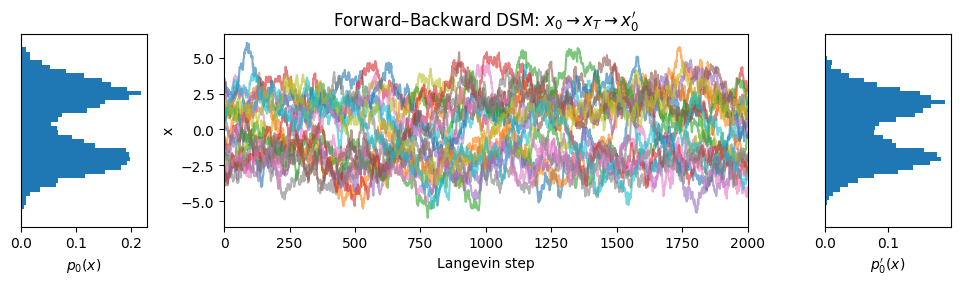

In [58]:
x0_np, xT_np, x0p_np, traj_hist = forward_backward_process(
    model, steps=2000, eta=0.02, x_dim=1, N_total=5000
)

fig = plt.figure(figsize=(12, 2.5))
gs = GridSpec(1, 3, width_ratios=[1.2, 5, 1.2], wspace=0.3)

ax_left  = fig.add_subplot(gs[0, 0])
ax_mid   = fig.add_subplot(gs[0, 1])
ax_right = fig.add_subplot(gs[0, 2])

# 左：p0(x)
ax_left.hist(x0_np[:,0], bins=40, density=True, orientation='horizontal')
ax_left.set_xlabel(r"$p_0(x)$")
ax_left.set_yticks([])

# ======================
# 中：軌跡 + xT histogram
# ======================

t_axis = np.arange(traj_hist.shape[0])

# 透明 histogram 疊在軌跡後面 (vertical histogram)
# ★ 注意：不能用 orientation='horizontal'，會被擋掉！
ax_mid.hist(
    xT_np[:,0],
    bins=35,
    density=True,
    alpha=0.25,
    color='lightskyblue'
)

# KDE 加在背景
import seaborn as sns
sns.kdeplot(
    xT_np[:,0],
    ax=ax_mid,
    color='blue',
    alpha=0.4,
    linewidth=2
)

# 軌跡
for i in range(traj_hist.shape[1]):
    ax_mid.plot(t_axis, traj_hist[:, i, 0], alpha=0.6)

ax_mid.set_xlabel("Langevin step")
ax_mid.set_ylabel("x")
ax_mid.set_title(r"Forward–Backward DSM: $x_0 \rightarrow x_T \rightarrow x_0'$")

# 中間的 x-limits
ax_mid.set_xlim(0, traj_hist.shape[0])

# ======================
# 右：p0'(x)
# ======================

ax_right.hist(x0p_np[:,0], bins=40, density=True, orientation='horizontal')
ax_right.set_xlabel(r"$p_0'(x)$")
ax_right.set_yticks([])

plt.tight_layout()
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_22896\1396603660.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


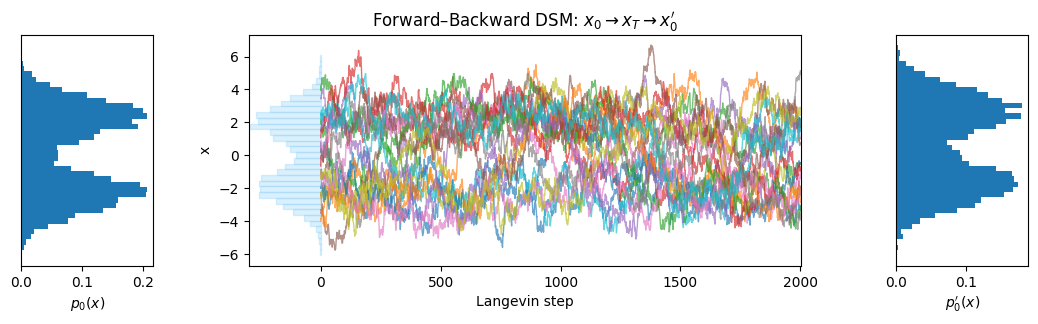

In [68]:
x0_np, xT_np, x0p_np, traj_hist = forward_backward_process(
    model, steps=2000, eta=0.02, x_dim=1, N_total=5000
)


fig = plt.figure(figsize=(13, 3))
gs = GridSpec(1, 3, width_ratios=[1.2, 5, 1.2], wspace=0.35)

ax_left  = fig.add_subplot(gs[0, 0])
ax_mid   = fig.add_subplot(gs[0, 1])
ax_right = fig.add_subplot(gs[0, 2])

# ==========================
# 左：真資料 p0(x)
# ==========================
ax_left.hist(x0_np[:,0], bins=40, density=True, orientation='horizontal')
ax_left.set_xlabel(r"$p_0(x)$")
ax_left.set_yticks([])

# ==============================
# 中：軌跡圖 + xT 的透明 histogram
# ==============================

t_axis = np.arange(traj_hist.shape[0])

# 先畫軌跡，後畫 histogram 陰影（不互相擋）
for i in range(traj_hist.shape[1]):
    ax_mid.plot(t_axis, traj_hist[:, i, 0], alpha=0.65, linewidth=1.0)

# 取得 y 軸範圍（x 值範圍）
ymin, ymax = ax_mid.get_ylim()

# 計算 histogram
hist_vals, hist_bins = np.histogram(xT_np[:,0], bins=35, density=True)

# 將 histogram 的高度 rescale → 只佔中間圖左側 15% 的寬度
max_width = 0.15 * traj_hist.shape[0]
hist_vals = hist_vals / hist_vals.max() * max_width

# 畫「沿 y 軸的半透明直方圖陰影」
for h, (y0, y1) in zip(hist_vals, zip(hist_bins[:-1], hist_bins[1:])):
    ax_mid.fill_betweenx([y0, y1], -h, 0,  # 左側區域：[-h, 0]
                         color='lightskyblue', alpha=0.30)

ax_mid.set_xlabel("Langevin step")
ax_mid.set_ylabel("x")
ax_mid.set_title(r"Forward–Backward DSM: $x_0 \rightarrow x_T \rightarrow x_0'$")

# 保護 histogram 陰影不要被自動縮放吃掉
ax_mid.set_xlim(-max_width, traj_hist.shape[0])

# ==========================
# 右：p0'(x)
# ==========================
ax_right.hist(x0p_np[:,0], bins=40, density=True, orientation='horizontal')
ax_right.set_xlabel(r"$p_0'(x)$")
ax_right.set_yticks([])

plt.tight_layout()
plt.show()
